In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  #Importamos librerías para usar
import scipy as scp 
from scipy import stats
import seaborn as sns

df = (pd.read_csv("FLIR_groups1and2.csv", sep=";" , header=2))[['Max1R13_1', 'Max1R13_2', 'Max1R13_3', 'Max1R13_4', 
        'aveOralM', 'Gender', 'Age', 'Ethnicity', 'T_atm', 'Humidity', 'Cosmetics']].copy() #cargamos el dataframe

#creamos la nueva columna con el valor promediado de Max1R13
df['Max1R13'] = df[['Max1R13_1', 'Max1R13_2', 'Max1R13_3', 'Max1R13_4']].mean(axis=1, skipna=True).astype(float)
#Eliminamos las columnas de Max1R13 que no son la promediada
df.drop(columns=['Max1R13_1', 'Max1R13_2', 'Max1R13_3', 'Max1R13_4'],inplace=True) 

print(df.isnull().sum()) #Corroboramos si hay datos nulos

#Veamos el comportamiento de los valores nulos de Cosmetics y como podemos tratarlos

        #Primero pasamos los datos a una string pues son categoricos, para poder tratarlos como categoricos 
df["Cosmetics"] = df["Cosmetics"].map({0.0: "No", 1.0: "Sí"}) 

print(f"\nmoda de cosmeticos: {df["Cosmetics"].mode()}")

b=df['Cosmetics'].fillna(df["Cosmetics"].mode())
print(f"mode de cosmeticos imputando con la moda: {b.mode()}\n")

#procedemos a imputar los valores nulos con la mediana

df["Cosmetics"] = df["Cosmetics"].fillna("No")

df.info()

SyntaxError: f-string: unmatched '[' (1072454266.py, line 23)

In [ ]:

# Columnas numéricas
df_num = df.select_dtypes(include=[np.number])

# Columnas categóricas (excluimos las numéricas)
df_cat = df.select_dtypes(exclude=[np.number])

metricas_num = pd.DataFrame({ 
    'Media': df_num.mean(), 
    'Mediana': df_num.median(),
    'Moda': df_num.mode().iloc[0],
    'SD': df_num.std(),
    'MAD': scp.stats.median_abs_deviation(df_num),
    'Varianza': df_num.var(),
    'IQR': df_num.quantile(0.75) - df_num.quantile(0.25),
    'CV %': (df_num.std() / df_num.median()),
    'CVM %': (scp.stats.median_abs_deviation(df_num) / df_num.median())
}).T

# Métricas para columnas categóricas: solo la Moda es significativa
indices = ["Media", "Mediana", "Moda", "SD", "MAD", "Varianza", "IQR", "CV %", "CVM %"]
metricas_cat = pd.DataFrame(index=indices, columns=df_cat.columns)
metricas_cat.loc["Moda"] = df_cat.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# Unir ambos DataFrames (las columnas no se traslapan)
metricas_completas = pd.concat([metricas_num, metricas_cat], axis=1)

# Reordenar las columnas según el orden original de df
metricas_completas = metricas_completas[df.columns]

print(metricas_completas)


           aveOralM  Gender    Age Ethnicity      T_atm    Humidity Cosmetics  \
Media     37.028382     NaN    NaN       NaN  24.115392   28.723039       NaN   
Mediana   36.940000     NaN    NaN       NaN  24.000000   26.300000       NaN   
Moda      36.890000  Female  18-20     White  24.000000   30.000000        No   
SD         0.509502     NaN    NaN       NaN   1.336338   13.071627       NaN   
MAD        0.200000     NaN    NaN       NaN   0.600000    8.900000       NaN   
Varianza   0.259593     NaN    NaN       NaN   1.785798  170.867427       NaN   
IQR        0.362500     NaN    NaN       NaN   1.300000   18.600000       NaN   
CV %       0.013793     NaN    NaN       NaN   0.055681    0.497020       NaN   
CVM %      0.005414     NaN    NaN       NaN   0.025000    0.338403       NaN   

            Max1R13  
Media     35.596533  
Mediana   35.548750  
Moda      35.677500  
SD         0.574888  
MAD        0.310000  
Varianza   0.330496  
IQR        0.625000  
CV %       0.

<h1>ANÁLISIS DEL SD Y MAD</h1>
<p>En todos los casos, la desviación estándar es notablemente mayor que la MAD, lo que sugiere la presencia de datos atípicos o una distribución no simétrica. Esto se debe a que la SD es más sensible a valores extremos, mientras que la MAD refleja mejor la dispersión típica sin verse tan afectada por outliers.</p>

<h2>DISPERSIÓN DE LOS DATOS SEGÚN EL COEFICIENTE DE VARIACIÓN</h2>
<p>Las variables aveOralM, T_atm y MaxIR13 tienen coeficientes de variación muy bajos, lo que indica que sus valores están concentrados cerca del valor central (mediana). La variable Humidity tiene un CV elevado (49.7%), lo que indica que es altamente dispersa, y refuerza la posibilidad de que contenga valores atípicos o esté afectada por una distribución sesgada. El coeficiente de variación confirma que, salvo Humidity, las variables están bien concentradas y no muy dispersas.</p>


In [ ]:
# Seleccionar únicamente las columnas numéricas
df_numeric = df.select_dtypes(include=[np.number])
datos_atipicos={}
contador_001 = 0
# Recorrer cada columna numérica
for col in df_numeric.columns:
    # Calcular percentiles e IQR una sola vez
    Q1 = np.nanpercentile(df_numeric[col], 25)
    Q3 = np.nanpercentile(df_numeric[col], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    # Imprimir el rango para verificación (opcional)
    print(f"Columna {col}: Lower Bound = {lower_bound}, Upper Bound = {upper_bound}")

        # Detectar e imprimir valores atípicos
    for value in df_numeric[col]:
        if value < lower_bound:
            datos_atipicos[f"{col}_{contador_001}"] = f"{value} es dato atípico en la columna {col} (inferior a {lower_bound})"
            contador_001 += 1
        elif value > upper_bound:
            datos_atipicos[f"{col}_{contador_001}"] = f"{value} es dato atípico en la columna {col} (superior a {upper_bound})"
            contador_001 += 1
print(f"DATOS ATIPICOS:")
datos_atipicos

Columna aveOralM: Lower Bound = 36.23375000000001, Upper Bound = 37.683749999999996
Columna T_atm: Lower Bound = 21.449999999999996, Upper Bound = 26.65
Columna Humidity: Lower Bound = -10.3, Upper Bound = 64.10000000000001
Columna Max1R13: Lower Bound = 34.31000000000002, Upper Bound = 36.80999999999999
DATOS ATIPICOS:


{'aveOralM_0': '37.79 es dato atípico en la columna aveOralM (superior a 37.683749999999996)',
 'aveOralM_1': '36.14 es dato atípico en la columna aveOralM (inferior a 36.23375000000001)',
 'aveOralM_2': '35.99 es dato atípico en la columna aveOralM (inferior a 36.23375000000001)',
 'aveOralM_3': '37.79 es dato atípico en la columna aveOralM (superior a 37.683749999999996)',
 'aveOralM_4': '37.99 es dato atípico en la columna aveOralM (superior a 37.683749999999996)',
 'aveOralM_5': '38.69 es dato atípico en la columna aveOralM (superior a 37.683749999999996)',
 'aveOralM_6': '38.54 es dato atípico en la columna aveOralM (superior a 37.683749999999996)',
 'aveOralM_7': '38.59 es dato atípico en la columna aveOralM (superior a 37.683749999999996)',
 'aveOralM_8': '36.09 es dato atípico en la columna aveOralM (inferior a 36.23375000000001)',
 'aveOralM_9': '37.79 es dato atípico en la columna aveOralM (superior a 37.683749999999996)',
 'aveOralM_10': '38.09 es dato atípico en la columna 

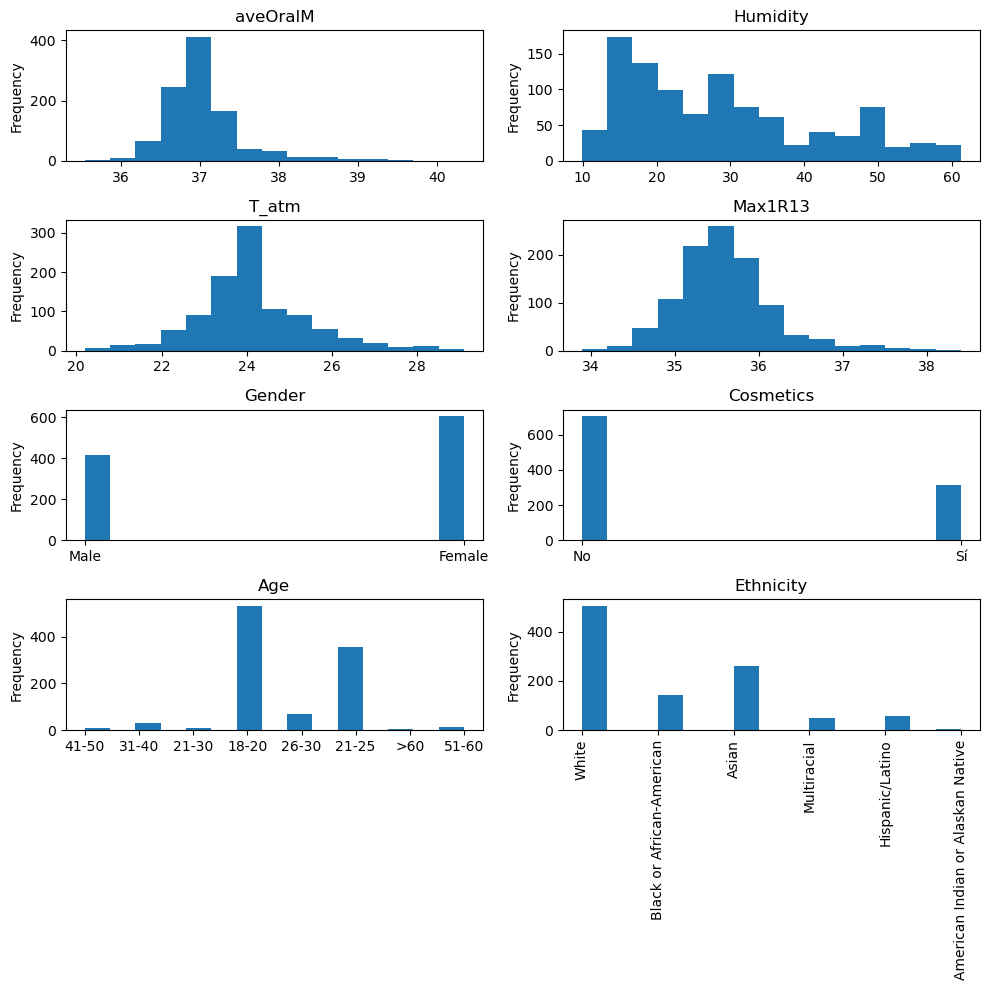

In [ ]:
#HISTOGRAMAS

fig, ax = plt.subplots(4,2,figsize=(10,10))

ax[0][0].hist(df['aveOralM'], bins=15)
ax[0][0].set_title("aveOralM")
ax[0][0].set_ylabel("Frequency")

ax[1][0].hist(df['T_atm'], bins=15)
ax[1][0].set_title("T_atm")
ax[1][0].set_ylabel("Frequency")

ax[0][1].hist(df['Humidity'], bins=15)
ax[0][1].set_title("Humidity")
ax[0][1].set_ylabel("Frequency")

ax[1][1].hist(df['Max1R13'], bins=15)
ax[1][1].set_title("Max1R13")
ax[1][1].set_ylabel("Frequency")

ax[2][0].hist(df['Gender'], bins=15)
ax[2][0].set_title("Gender")
ax[2][0].set_ylabel("Frequency")

ax[3][1].hist(df['Ethnicity'], bins=15)
ax[3][1].set_title("Ethnicity")
ax[3][1].set_ylabel("Frequency")
ax[3][1].tick_params(axis='x', rotation=90) 

ax[3][0].hist(df['Age'], bins=15)
ax[3][0].set_title("Age")
ax[3][0].set_ylabel("Frequency")

ax[2][1].hist(df['Cosmetics'], bins=15)
ax[2][1].set_title("Cosmetics")
ax[2][1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

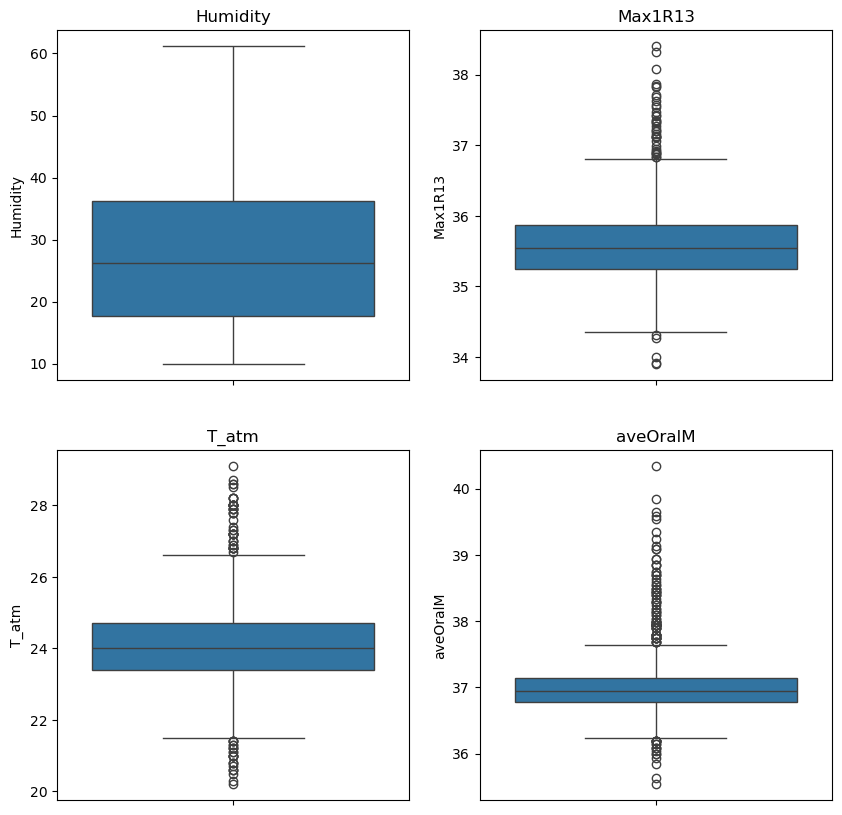

In [ ]:
#GRAFICOS DE CAJAS Y BIGOTES

fig, ax = plt.subplots(2,2,figsize=(10,10))

sns.boxplot(data=df_num["Humidity"], ax=ax[0][0])
ax[0][0].set_title('Humidity')

sns.boxplot(data=df_num["Max1R13"], ax=ax[0][1])
ax[0][1].set_title("Max1R13")

sns.boxplot(data=df_num["T_atm"], ax=ax[1][0])
ax[1][0].set_title('T_atm')

sns.boxplot(data=df_num["aveOralM"], ax=ax[1][1])
ax[1][1].set_title('aveOralM')

plt.show()


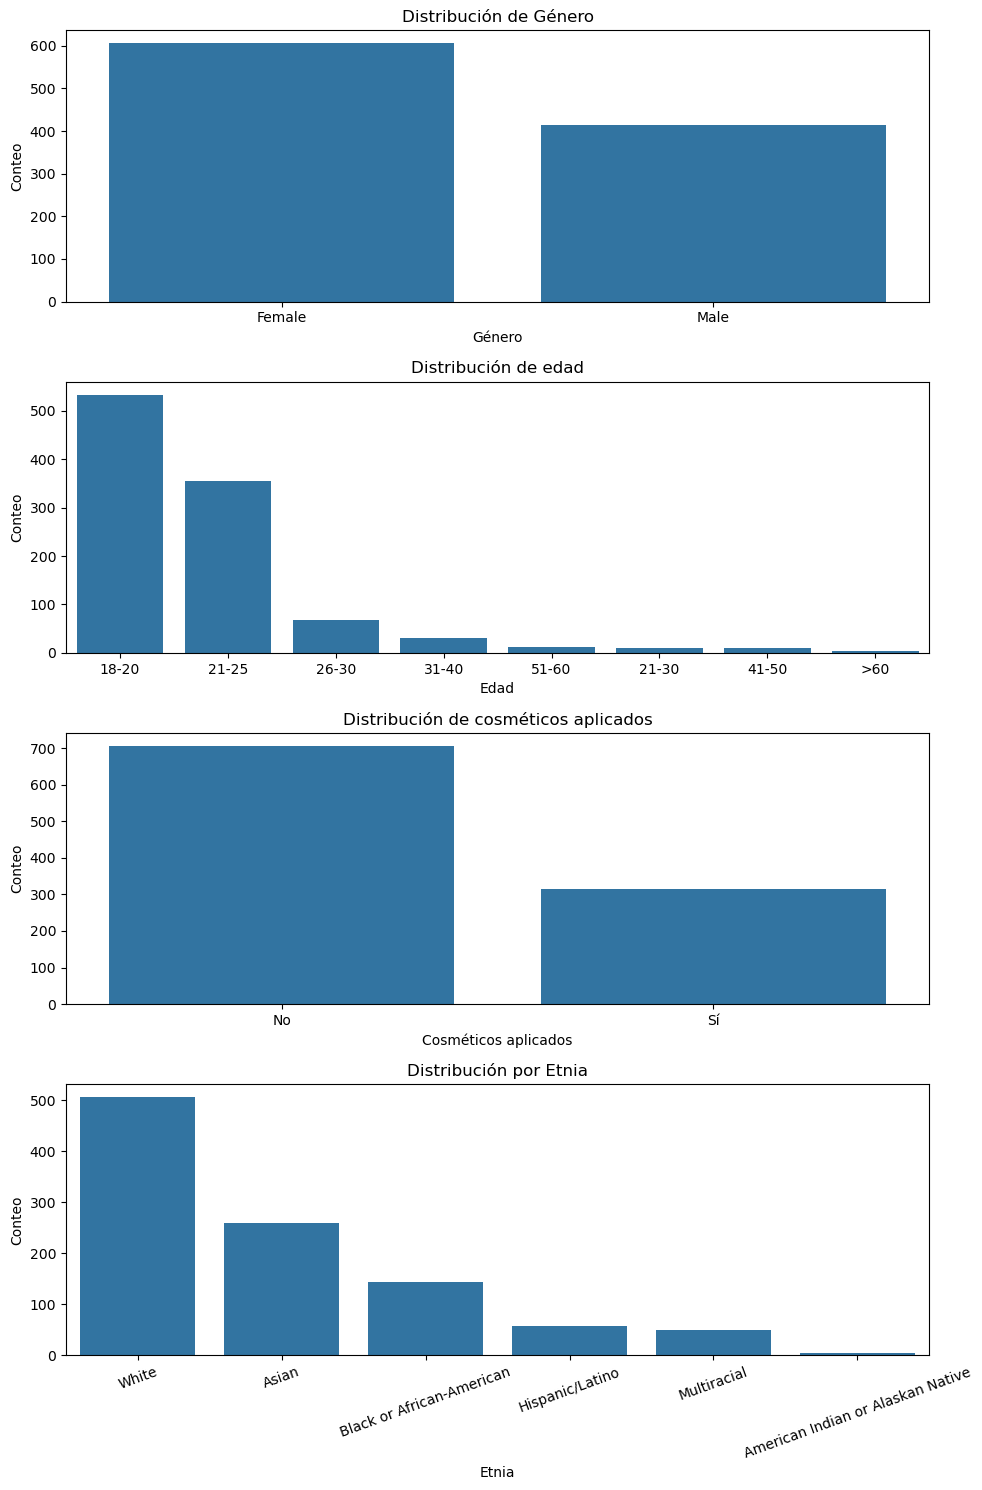

In [ ]:
#GRÁFICOS DE BARRA

df_cat["Gender"].value_counts()
df_cat["Age"].value_counts()
df_cat["Cosmetics"].value_counts()
df_cat["Ethnicity"].value_counts()

fig, ax = plt.subplots(4, 1, figsize=(10, 15))


sns.barplot(x=df_cat["Gender"].value_counts().index, 
            y=df_cat["Gender"].value_counts().values, ax=ax[0])
ax[0].set_title("Distribución de Género")
ax[0].set_xlabel("Género")
ax[0].set_ylabel("Conteo")

sns.barplot(x=df_cat["Age"].value_counts().index, 
            y=df_cat["Age"].value_counts().values, ax=ax[1])
ax[1].set_title("Distribución de edad")
ax[1].set_xlabel("Edad")
ax[1].set_ylabel("Conteo")

sns.barplot(x=df_cat["Cosmetics"].value_counts().index, 
            y=df_cat["Cosmetics"].value_counts().values, ax=ax[2])
ax[2].set_title("Distribución de cosméticos aplicados")
ax[2].set_xlabel("Cosméticos aplicados")
ax[2].set_ylabel("Conteo")

sns.barplot(x=df_cat["Ethnicity"].value_counts().index, 
            y=df_cat["Ethnicity"].value_counts().values, ax=ax[3].tick_params(axis='x', rotation=20) )
ax[3].set_title("Distribución por Etnia")
ax[3].set_xlabel("Etnia")
ax[3].set_ylabel("Conteo")

plt.tight_layout()
plt.show()

          aveOralM     T_atm  Humidity   Max1R13
aveOralM  1.000000  0.098663  0.063595  0.741902
T_atm     0.098663  1.000000  0.119270  0.275363
Humidity  0.063595  0.119270  1.000000  0.050884
Max1R13   0.741902  0.275363  0.050884  1.000000


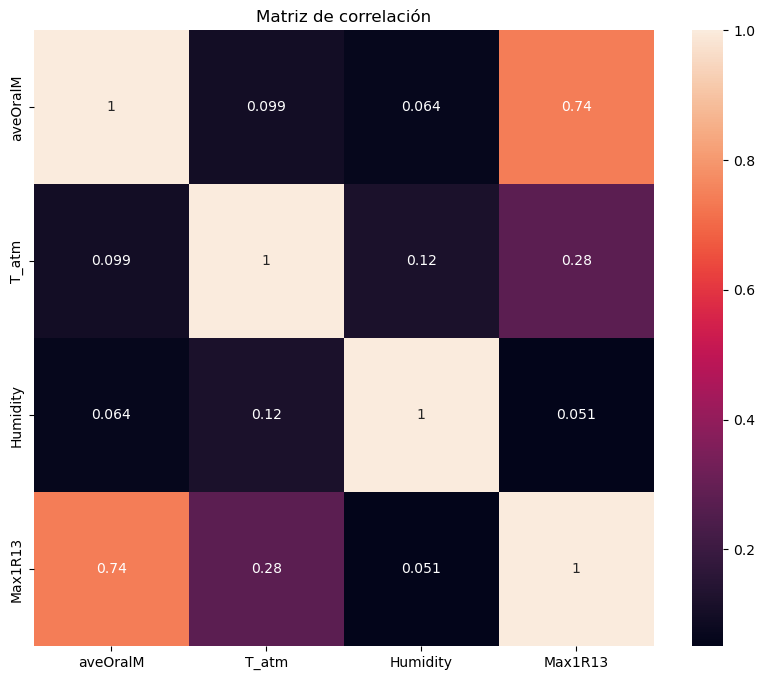

In [ ]:
## Matriz de correlacion 

# Calcula la matriz de correlación, que por defecto usa el coeficiente de correlación de Pearson.
correlation_matrix = df_num.corr()

# Muestra la matriz de correlación por consola (opcional)
print(correlation_matrix)

# Visualiza la matriz de correlación con un heatmap de Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.title("Matriz de correlación")
plt.show()


<h1> MUESTREO DE LOS DATOS

In [ ]:
# Realizar muestreo aleatorio de 500 filas
df_muestra = df.sample(n=500)

# Columnas numéricas
df_mues_num = df_muestra.select_dtypes(include=[np.number])

# Columnas categóricas (excluimos las numéricas)
df_mues_cat = df_muestra.select_dtypes(exclude=[np.number])

metricas_num_muestra = pd.DataFrame({ 
    'Media': df_mues_num.mean(), 
    'Mediana': df_mues_num.median(),
    'Moda': df_mues_num.mode().iloc[0],
    'SD': df_mues_num.std(),
    'MAD': scp.stats.median_abs_deviation(df_mues_num),
    'Varianza': df_mues_num.var(),
    'IQR': df_mues_num.quantile(0.75) - df_mues_num.quantile(0.25),
    'CV %': (df_mues_num.std() / df_mues_num.median()),
    'CVM %': (scp.stats.median_abs_deviation(df_mues_num) / df_mues_num.median())
}).T

# Métricas para columnas categóricas: solo la Moda es significativa
indices = ["Media", "Mediana", "Moda", "SD", "MAD", "Varianza", "IQR", "CV %", "CVM %"]
metricas_cat_muestra = pd.DataFrame(index=indices, columns=df_mues_cat.columns)
metricas_cat_muestra.loc["Moda"] = df_mues_cat.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# Unir ambos DataFrames (las columnas no se traslapan)
metricas_completas_random = pd.concat([metricas_num_muestra, metricas_cat_muestra], axis=1)

# Reordenar las columnas según el orden original de df
metricas_completas = metricas_completas_random[df_muestra.columns]

print(metricas_completas)


           aveOralM  Gender    Age Ethnicity      T_atm    Humidity Cosmetics  \
Media     37.028500     NaN    NaN       NaN  24.159200   29.266600       NaN   
Mediana   36.940000     NaN    NaN       NaN  24.000000   27.300000       NaN   
Moda      36.890000  Female  18-20     White  24.000000   30.000000        No   
SD         0.510513     NaN    NaN       NaN   1.398932   12.910597       NaN   
MAD        0.200000     NaN    NaN       NaN   0.600000    9.550000       NaN   
Varianza   0.260624     NaN    NaN       NaN   1.957009  166.683511       NaN   
IQR        0.400000     NaN    NaN       NaN   1.400000   19.125000       NaN   
CV %       0.013820     NaN    NaN       NaN   0.058289    0.472916       NaN   
CVM %      0.005414     NaN    NaN       NaN   0.025000    0.349817       NaN   

            Max1R13  
Media     35.596400  
Mediana   35.558750  
Moda      35.415000  
SD         0.591371  
MAD        0.320000  
Varianza   0.349720  
IQR        0.640000  
CV %       0.

In [ ]:
import numpy as np
import pandas as pd

# Supongamos que df tiene una columna 'Age' en formato categórico (strings o categorías).
# Por ejemplo: "18-20", "21-30", "31-40", etc.

# Paso 1: Lista de categorías únicas en Age (ignora nulos si los hubiera)
stratas = df['Age'].dropna().unique()

# Paso 2: Cálculo del tamaño de la muestra total que deseas
N_TOTAL = 500

# Paso 3: Muestreo estratificado manual
df_strat = pd.DataFrame()

for s in stratas:
    # Filtra la subpoblación que pertenece al estrato 's'
    subset = df[df['Age'] == s]
    
    # Calcula cuántas filas tomar de este estrato, proporcional a su tamaño
    n_s = int(len(subset) / len(df) * N_TOTAL)
    
    # Si el estrato es muy pequeño, podrías usar min(len(subset), n_s) para no pasarte
    if n_s > 0:
        df_strat = pd.concat([df_strat, subset.sample(n=n_s, random_state=42)])

# Si por cuestiones de redondeo no llegaste justo a 500, 
# podrías tomar algunos registros adicionales de los estratos más grandes
if len(df_strat) < N_TOTAL:
    faltan = N_TOTAL - len(df_strat)
    # Por simplicidad, puedes tomar el resto de cualquier estrato grande
    # o redistribuirlo de forma proporcional
    estrato_mas_grande = df.groupby('Age').size().idxmax()
    subset = df[df['Age'] == estrato_mas_grande]
    df_strat = pd.concat([df_strat, subset.sample(n=faltan, random_state=99)])

df_strat.reset_index(drop=True, inplace=True)

# df_strat es tu muestra estratificada final con ~500 registros.
import scipy as scp
from scipy import stats

# Columnas numéricas en df_strat
df_strat_num = df_strat.select_dtypes(include=[np.number])

# Columnas categóricas en df_strat
df_strat_cat = df_strat.select_dtypes(exclude=[np.number])

metricas_num_estrat = pd.DataFrame({
    'Media': df_strat_num.mean(),
    'Mediana': df_strat_num.median(),
    'Moda': df_strat_num.mode().iloc[0],
    'SD': df_strat_num.std(),
    'MAD': scp.stats.median_abs_deviation(df_strat_num),
    'Varianza': df_strat_num.var(),
    'IQR': df_strat_num.quantile(0.75) - df_strat_num.quantile(0.25),
    'CV %': (df_strat_num.std() / df_strat_num.median()),
    'CVM %': (scp.stats.median_abs_deviation(df_strat_num) / df_strat_num.median())
}).T

# Métricas para columnas categóricas: solo la Moda es significativa
indices = ["Media", "Mediana", "Moda", "SD", "MAD", "Varianza", "IQR", "CV %", "CVM %"]
metricas_cat_estrat = pd.DataFrame(index=indices, columns=df_strat_cat.columns)
metricas_cat_estrat.loc["Moda"] = df_strat_cat.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# Unir ambos DataFrames (las columnas no se traslapan)
metricas_completas_estrat = pd.concat([metricas_num_estrat, metricas_cat_estrat], axis=1)

# (Opcional) Reordenar columnas si deseas reflejar el mismo orden que df_strat
metricas_completas_estrat = metricas_completas_estrat[df_strat.columns]

print(metricas_completas_estrat)


           aveOralM  Gender    Age Ethnicity      T_atm    Humidity Cosmetics  \
Media     37.033200     NaN    NaN       NaN  24.130200   28.914800       NaN   
Mediana   36.990000     NaN    NaN       NaN  24.000000   27.200000       NaN   
Moda      37.040000  Female  18-20     White  24.000000   13.500000        No   
SD         0.460465     NaN    NaN       NaN   1.349589   13.022725       NaN   
MAD        0.200000     NaN    NaN       NaN   0.650000    9.600000       NaN   
Varianza   0.212028     NaN    NaN       NaN   1.821391  169.591364       NaN   
IQR        0.350000     NaN    NaN       NaN   1.300000   18.975000       NaN   
CV %       0.012448     NaN    NaN       NaN   0.056233    0.478777       NaN   
CVM %      0.005407     NaN    NaN       NaN   0.027083    0.352941       NaN   

            Max1R13  
Media     35.576240  
Mediana   35.528750  
Moda      35.710000  
SD         0.538400  
MAD        0.291250  
Varianza   0.289875  
IQR        0.583125  
CV %       0.